# Swan Teleco Retention Strategies

### Churn No More

In [2]:
# Import the required libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import the data
df = pd.read_excel("1 - Project Data.xlsx")

---

## EDA 1

#### Further information about the columns
> The columns that we are going to use as features for predictive modelling are in **bold**.
> The target that our model will predict is _**Churn Value**_.

Customer:
* 'CustomerID' (object) : in the form 1234-ABCDE, all unique
* 'Count' (int64): all = 1

Location:
* 'Country' (object) : all = 'United States'
* 'State' (object) : all = 'California'
* 'City' (object) : 1129 unique values
* 'Zip Code' (int64) : in the form 9----, 1652 unique values
* 'Lat Long' (object) : in the form 'Latitude' 'Longitude', 1652 unique values
* 'Latitude' (float64) : in the form 00.000000, 1652 unique values
* 'Longitude' (float64) : in the form -000.000000, 1651 unique values

Customer Details:
* **'Gender'** (object) : 'Male' or 'Female', [3555 = 'Male', 3488 = 'Female']
* **'Senior Citizen'** (object) : 'No' or 'Yes', ['No' = 5901, 'Yes' = 1142]
* **'Partner'** (object) : 'No' or 'Yes', ['No' = 3641, 'Yes' = 3402]
* **'Dependents'** (object) : 'No' or 'Yes', ['No' = 5416, 'Yes' = 1627]

Phone Service Info:
* **'Phone Service'** (object) : 'No' or 'Yes', ['No' = 682, 'Yes' = 6361]
* **'Multiple Lines'** (object) : 'No' or 'Yes' or 'No phone service', ['No' = 3390, 'Yes' = 2971, 'No phone service' = 682]

Internet Service Info
* **'Internet Service'** (object) : ['Fiber optic' = 3096, 'DSL' = 2421, 'No' = 1526]
* **'Online Security'** (object) : 'No' or 'Yes' or 'No internet service, ['No' = 3498, 'Yes' = 2019, 'No internet service' = 1526]
* **'Online Backup'** (object) : 'No' or 'Yes' or 'No internet service, ['No' = 3088, 'Yes' = 2429, 'No internet service' = 1526]
* **'Device Protection'** (object) :'No' or 'Yes' or 'No internet service, ['No' = 3095, 'Yes' = 2422, 'No internet service' = 1526]
* **'Tech Support'** (object) : 'No' or 'Yes' or 'No internet service, ['No' = 3473, 'Yes' = 2044, 'No internet service' = 1526]
* **'Streaming TV'** (object) : 'No' or 'Yes' or 'No internet service, ['No' = 2810, 'Yes' = 2707, 'No internet service' = 1526]
* **'Streaming Movies'** (object) : 'No' or 'Yes' or 'No internet service, ['No' = 2785, 'Yes' = 2732, 'No internet service' = 1526]

Contract and Payement:
* **'Tenure Months'** (int64) : integer in range (0,72), 73 unique values
* **'Contract'** (object) : 'Month-to-month' or 'One year' or 'Two year', ['Month-to-month' = 3875, 'One year' = 1473, 'Two year' = 1695']
* **'Paperless Billing'** (object) : 'No' or 'Yes', ['No' = 4171, 'Yes' = 2872]
* **'Payment Method'** (object) : 4 unique values, ['Electronic check' = 2365, 'Mailed check' = 1612, 'Bank transfer (automatic)' = 1544, 'Credit card (automatic)' = 1522]
* **'Monthly Charges'** (float64) : float in range (18.25, 118.75), 1585 unique values
* **'Total Charges'** (object) : 6531 unique values, need to change dtype to float64:
    * Total Charges = ' ' when Tenure Months = 0, since these customers haven't been charged yet
    * Change these to 0 or null

Churning:
* 'Churn Label' (object) : 'No' or 'Yes' ['No' = 5174,'Yes' = 1869]
* _**'Churn Value'**_ (int64) : 0 or 1, [0 = 5174, 1 = 1869], corresponds to 'Churn Label' values
* 'Churn Reason' (object) : 20 unique values + NULLS corresponding to 'Churn Label' = 0

**Notes**:
* There are 7043 data entries.
* There are 31 columns
* There are many columns with an `object` datatype which won't work for modelling.
* There are a lot of null values in the `Churn Reason` column.

---

## Train test splitting

First we balance the dataset to allow for better model performance. We do this by separating the churned customers from the non-churned customers and taking an equally sized number of samples from the non-churned customers.

In [106]:
churned = df[df['Churn Value'] == 1].copy()
non_churned = df[df['Churn Value'] == 0].copy()
non_churned_sample = non_churned.sample(n = len(churned))
balanced_df = pd.concat([non_churned_sample, churned])

Next we split the balanced dataset into the training and testing data.

In [13]:
# Split into the feature and target
feature_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges']
X = balanced_df[feature_cols].copy()
y = balanced_df['Churn Value'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

---

## Feature engineering

To use the features in our model we convert them to numerical datatypes. This is done largely using mapping, where 'No' is mapped to 0 and 'Yes' is mapped to 1 but also using one-hot-encoding for the features with different service names.

In [17]:
# Map the Yes/No columns to make them numeric and OHE the columns with categories
def feature_eng(df):
    df = df.copy()
    df['Gender'] = df['Gender'].map({'Female':0, 'Male':1, 0:0, 1:1})
    df['Senior Citizen'] = df['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Partner'] = df['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Dependents'] = df['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Phone Service'] = df['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Multiple Lines'] = df['Multiple Lines'].map({'No':0, 'Yes':1, 'No phone service': 0, 0:0, 1:1})
    df['Online Security'] = df['Online Security'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Online Backup'] = df['Online Backup'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Device Protection'] = df['Device Protection'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Tech Support'] = df['Tech Support'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Streaming TV'] = df['Streaming TV'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Streaming Movies'] = df['Streaming Movies'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})

    # We found entries in total charges containing only a white space which corresponded to customers who have 0 tenure months.
    # Change these spaces to 0.
    # Change the total charges column to a float.
    df['Total Charges'] = df['Total Charges'].replace(' ', '0')
    df['Total Charges'] = df['Total Charges'].astype('float64')
    
    df = pd.get_dummies(data = df, columns = ['Internet Service'], prefix='Internet', dtype = int, drop_first = True)
    df = pd.get_dummies(data = df, columns = ['Contract'], prefix='Contract', dtype = int, drop_first = True)
    df = pd.get_dummies(data = df, columns = ['Payment Method'], prefix='Payment', dtype = int, drop_first = True)
    
    return df

In [18]:
X_train_fe = feature_eng(X_train)

---

## Create the model

We use logistic regression to fit our model as this performs slightly better than a random forest. 

In [22]:
feature_cols = ['Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Monthly Charges', 'Total Charges',
       'Internet_Fiber optic', 'Internet_No', 'Contract_One year',
       'Contract_Two year', 'Payment_Credit card (automatic)',
       'Payment_Electronic check', 'Payment_Mailed check']
X_train_model = X_train_fe[feature_cols].copy()
log_reg = LogisticRegression(max_iter = 4000, random_state = 42)
log_reg.fit(X_train_model, y_train)

LogisticRegression(max_iter=4000, random_state=42)

Before analysing the metrics we check the importance of each of the features to see which are influencing the model the most. 

In [24]:
# Display coefficients alongside feature names
feature_importance = pd.DataFrame({
    'Feature': X_train_model.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)
feature_importance

,Feature,Coefficient
3,Dependents,-1.445970
19,Contract_Two year,-1.248335
17,Internet_No,-0.827428
16,Internet_Fiber optic,0.662390
18,Contract_One year,-0.638849
5,Phone Service,-0.571137
13,Paperless Billing,0.417174
2,Partner,0.360984
6,Multiple Lines,0.332896
10,Tech Support,-0.327423


Dependents, contract length and internet services are the top contributing features, agreeing with the further EDA performed below in a few sections time.

In [26]:
X_train_model[['prob_0', 'prob_1']] = log_reg.predict_proba(X_train_model)
X_train_model['y_pred'] = np.where(X_train_model['prob_1'] >= 0.5, 1, 0) 

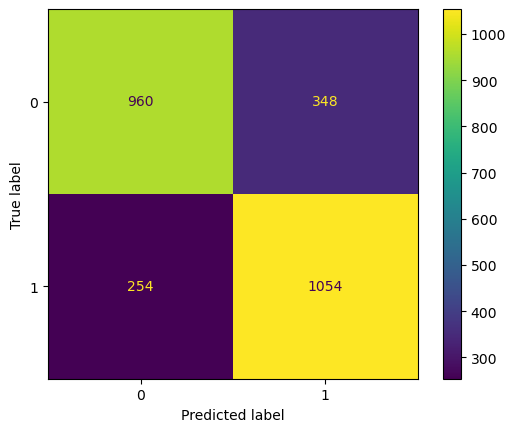

In [27]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_train, X_train_model['y_pred'])).plot()
plt.show()

Continuing with the model analysis we find that the model predicts whether or not customers have churned very well. The majority of data points are along the diagonal, although there are slightly more false positives predicted than false negatives. This is reflected in the metrics below:

In [29]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')
get_results(y_train, X_train_model['y_pred'])

The confusion matrix for your predictions is:
[[ 960  348]
 [ 254 1054]] 

The accuracy of your model is: 0.7698776758409785
The recall of your model is: 0.8058103975535168
The precision of your model is: 0.7517831669044223
The F1-score of your model is: 0.777859778597786


All metrics on the training data are above 75%, with recall achiveing the highest performance at 81%.

---

## Model testing

To test our model we first transform the testing data with our feature engineering function.

In [34]:
X_test_fe = feature_eng(X_test)

Then we create an empty dataframe which we populate with the predictions for each customer given by our model.

In [36]:
predictions = pd.DataFrame(index=X_test.index)
predictions[['prob_0', 'prob_1']] = log_reg.predict_proba(X_test_fe[feature_cols])
predictions['y_pred'] = np.where(predictions['prob_1'] >= 0.5, 1, 0) 

To analyse the model we check the confusion matrix and look at our performance metrics.

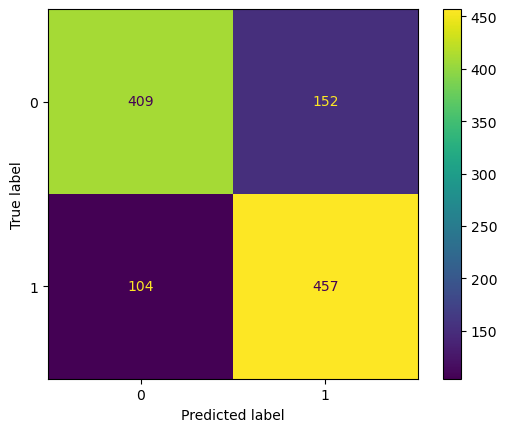

In [38]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predictions['y_pred'])).plot()
plt.show()

In [39]:
get_results(y_test, predictions['y_pred'])

The confusion matrix for your predictions is:
[[409 152]
 [104 457]] 

The accuracy of your model is: 0.7718360071301248
The recall of your model is: 0.8146167557932263
The precision of your model is: 0.7504105090311987
The F1-score of your model is: 0.7811965811965812


Again, these metrics are all above 75% and they're all within 1% of the training metrics so this is evidence that the model isn't overfitting and it's generalisable to new data.

---

## Churn risk for all current customers

To find the churn risk for all remaining customers their data is split into their features and the target (churn value). Feature engineering is performed on the data and then the model is used to predict the probability of churning for each one.

In [43]:
# Separate churned and non-churned customers
feature_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges']
X = non_churned[feature_cols].copy()
y = non_churned['Churn Value'].copy()

In [44]:
non_churned_fe = feature_eng(X)

In [119]:
feature_cols = ['Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Monthly Charges', 'Total Charges',
       'Internet_Fiber optic', 'Internet_No', 'Contract_One year',
       'Contract_Two year', 'Payment_Credit card (automatic)',
       'Payment_Electronic check', 'Payment_Mailed check']
non_churned_model = non_churned_fe[feature_cols].copy()
non_churned_model[['prob_0', 'prob_1']] = log_reg.predict_proba(non_churned_model)
non_churned_model['y_pred'] = np.where(non_churned_model['prob_1'] >= 0.5, 1, 0) 

In [115]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [168]:
# Add the customer IDs into the non_churned_model dataframe and extract the customer ID and the probability of churning
non_churned_model['CustomerID'] = df['CustomerID']
churn_risk = non_churned_model[['CustomerID', 'prob_1']]
churn_risk = churn_risk.rename(columns = {'prob_1': 'Probability of Churning'})
churn_risk.to_csv("churn_risk.csv", index = False)

---

## Top 500 churn risk

To find the customers most at risk of churning these predictions are sorted so that the probability of churning is closest to 1 and the top 500 are selected.

In [166]:
# Filter for the top 500 highest risk customers
# Add the customer IDs into the top_500 dataframe and extract the customer ID and the probability of churning
top_500 = non_churned_model.sort_values(by = 'prob_1', ascending = False).head(500)
top_500['CustomerID'] = df['CustomerID']
top_500_churn_risk = top_500[['CustomerID', 'prob_1']]
top_500_churn_risk = top_500_churn_risk.rename(columns = {'prob_1': 'Probability of Churning'})
top_500_churn_risk.to_csv("top_500_churn_risk.csv", index = False)

---

## EDA 2 - Visualisations for the information presentation deck

To get a broad overview of the churned and non-churned customers we first look at their split in the dataset.

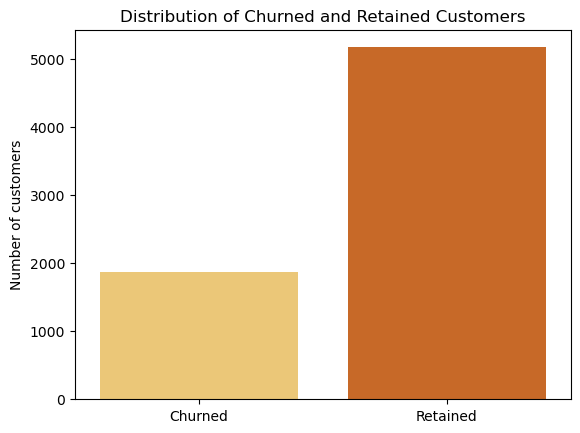

In [53]:
# Churn distribution
sns.countplot(data=df, 
              x='Churn Label', 
              hue = 'Churn Label',
              palette='YlOrBr')
plt.title('Distribution of Churned and Retained Customers')
plt.ylabel('Number of customers')
plt.xticks(ticks=[0, 1], labels=['Churned', 'Retained'])
plt.xlabel('')
plt.savefig('churn_dist_plot.png', bbox_inches='tight')
plt.show()

The majority of customers in the dataset (73%) have not churned.

Next we look at the overall demographics of these churned customers to see what features they have in common.

In [55]:
# Analysing demographics: gender, seniority, partner, dependents and products.
demographics = churned[['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies']].describe()
demographics.loc[['count','top','freq']]

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies
count,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869
top,Female,No,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No
freq,939,1393,1200,1763,1699,850,1297,1461,1233,1211,1446,942,938


The table shows that in general the churned customers are female, have no partner or dependents, and have opted only for services related to phones. Additionally, the internet service they opt for most frequently is fibre-optic.

To explore the churners demographic in more depth we create a new dataframe to focus on the features gender, senior citizen, partner and dependents. This includes each features' percentage share within the churned and non-churned categories.

In [57]:
# Create a new dataframe to focus on the features gender, senior citizen, partner and dependents.
df_fe = feature_eng(df)
demog_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Churn Value']
demog = df_fe.groupby('Churn Value')[demog_cols].sum().astype(float)
demog.loc[[0],['Churn Value']] = len(df_fe[df_fe['Churn Value'] == 0])
demog.loc['not churned (%)'] = [100*2526/5174, 100*666/5174, 100*2733/5174, 100*1521/5174, 100*1]
demog.loc['churned (%)'] = [100*930/1869, 100*476/1869, 100*669/1869, 100*106/1869, 100*1]
demog.rename(columns = {'Gender' : 'Male'}, inplace = True)
demog

,Male,Senior Citizen,Partner,Dependents,Churn Value
Churn Value,,,,,
0,2625.000000,666.000000,2733.000000,1521.000000,5174.0
1,930.000000,476.000000,669.000000,106.000000,1869.0
not churned (%),48.821028,12.872053,52.821801,29.396985,100.0
churned (%),49.759230,25.468165,35.794543,5.671482,100.0


<Figure size 800x500 with 0 Axes>

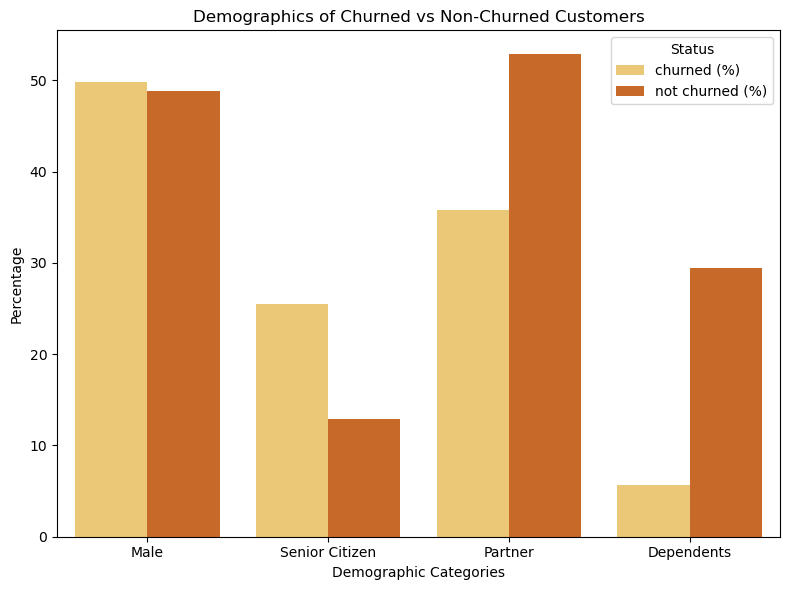

In [58]:
plt.figure(figsize = (8,5))
# Reshape the DataFrame using melt
demog_melted = demog.loc[['churned (%)', 'not churned (%)'], ['Male', 'Senior Citizen', 'Partner', 'Dependents']].reset_index()
demog_melted = demog_melted.melt(id_vars='Churn Value', 
                                 var_name='Category', 
                                 value_name='Percentage')
# Plot the grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=demog_melted, 
            x='Category', 
            y='Percentage', 
            hue='Churn Value', 
            palette='YlOrBr')
plt.title('Demographics of Churned vs Non-Churned Customers')
plt.ylabel('Percentage')
plt.xlabel('Demographic Categories')
plt.legend(title='Status')
plt.tight_layout()
plt.savefig('churn_vs_nonchurn.png', bbox_inches='tight')
plt.show()

The bargraph above shows that the percentage of senior citizens among churners is twice as high as that among non-churners. In contrast, customers with dependents or partners are less likely to churn, as the percentage of churners with dependents is notably lower than that of non-churners.

This is reinforced by the heatmap of correlations below. Customers with dependents and/or partners are less likely to churn, showing a negative correlation with churning. In contrast, senior citizens show a 15% positive correlation, indicating that they're more likely to churn. Both plots show very little relationship between gender and churn status.

In [60]:
# Alter the feature engineering function so it doesn't drop the columns in the OHE.
def feature_eng2(df):
    df = df.copy()
    df['Gender'] = df['Gender'].map({'Female':0, 'Male':1, 0:0, 1:1})
    df['Senior Citizen'] = df['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Partner'] = df['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Dependents'] = df['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Phone Service'] = df['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Multiple Lines'] = df['Multiple Lines'].map({'No':0, 'Yes':1, 'No phone service': 0, 0:0, 1:1})
    df['Online Security'] = df['Online Security'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Online Backup'] = df['Online Backup'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Device Protection'] = df['Device Protection'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Tech Support'] = df['Tech Support'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Streaming TV'] = df['Streaming TV'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Streaming Movies'] = df['Streaming Movies'].map({'No':0, 'Yes':1, 'No internet service': 0, 0:0, 1:1})
    df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})

    # Change the total charges column to a float (and remove the spaces for 0 month customers)
    df['Total Charges'] = df['Total Charges'].replace(' ', '0')
    df['Total Charges'] = df['Total Charges'].astype('float64')
    
    df = pd.get_dummies(data = df, columns = ['Internet Service'], prefix='Internet', dtype = int)
    df = pd.get_dummies(data = df, columns = ['Contract'], prefix='Contract', dtype = int)
    df = pd.get_dummies(data = df, columns = ['Payment Method'], prefix='Payment', dtype = int)
    
    return df

In [61]:
df_fe2 = feature_eng2(df)

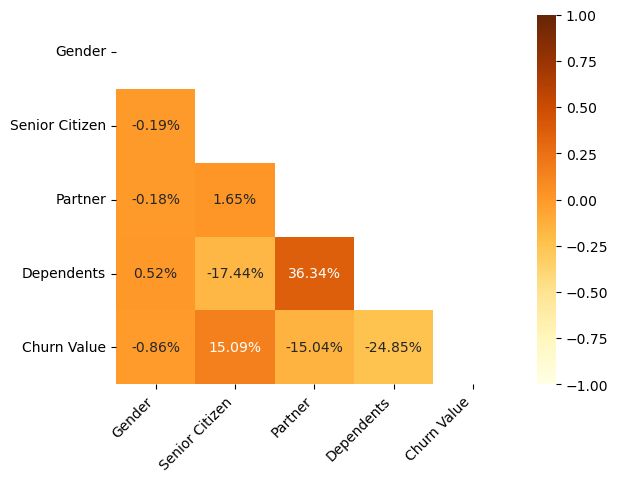

In [62]:
# Create a heatmap showing the correlation between the demographic columns and the Churn Value.
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(df_fe2[demog_cols].corr(),
            vmin = -1,
            vmax = 1,
            cmap = "YlOrBr",
            annot = True,
            fmt = '.2%',
            mask = np.triu(df_fe2[demog_cols].corr()))
plt.xticks(rotation = 45,
          horizontalalignment = 'right')
plt.savefig('demog correlation.png', bbox_inches='tight')
plt.show()

**Notes:**
* `Gender` has almost no correlation with `Churn Value`.
* `Senior Citizen` has a weak positive correlation with `Churn Value`.
* `Partner` has a weak negative correlation with `Churn Value`.
* `Dependents` has a negative correlation with `Churn Value`.

Following on from this we decide to investigate the factors which might retain customers the best so we can suggest a sign-up metric to incentivise. 

The two most influential services that Swan Teleco offer are online security and online backup.

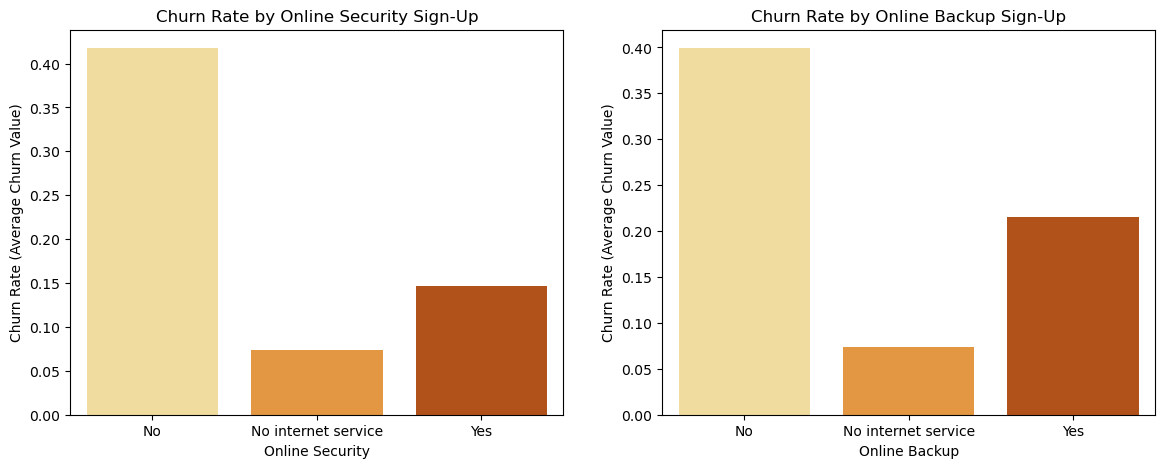

In [65]:
# Group by Online Security in the first dataframe and Online Backup in the second. Then calculate churn rate.
online_security_churn = df.groupby('Online Security')['Churn Value'].mean()
online_backup_churn = df.groupby('Online Backup')['Churn Value'].mean()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    ax=axes[0], 
    x=online_security_churn.index, 
    y=online_security_churn.values, 
    hue=online_security_churn.index, 
    palette='YlOrBr')
axes[0].set_title("Churn Rate by Online Security Sign-Up")
axes[0].set_xlabel("Online Security")
axes[0].set_ylabel("Churn Rate (Average Churn Value)")

sns.barplot(
    ax=axes[1], 
    x=online_backup_churn.index, 
    y=online_backup_churn.values, 
    hue=online_backup_churn.index, 
    palette='YlOrBr')
axes[1].set_title("Churn Rate by Online Backup Sign-Up")
axes[1].set_xlabel("Online Backup")
axes[1].set_ylabel("Churn Rate (Average Churn Value)")
plt.show()

Customers who sign up for online security services are more likely to remain with the company, making it a key factor in customer retention. The data reveals that a higher proportion of customers churned without online security compared to those without online backup. Therefore, prioritizing online security as an incentive for sign-ups would likely have the most significant impact on reducing churn.

As well as focusing on which services tend to keep customers, we also look at factors which correlate with them leaving.

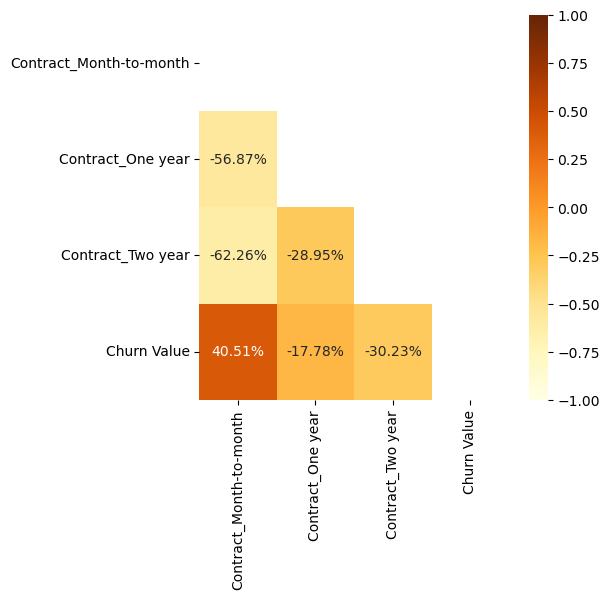

In [67]:
contract_cols = ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'Churn Value']
plt.figure(figsize = (5,5))
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(df_fe2[contract_cols].corr(),
            vmin = -1,
            vmax = 1,
            annot = True,
            cmap = 'YlOrBr',
            fmt = '.2%',
            mask = np.triu(df_fe2[contract_cols].corr()))
plt.savefig('churn_vs_contract.png', bbox_inches='tight')
plt.show()

Customers on month-to-month contracts exhibit a high churn rate, with a positive correlation of 40.51% to Churn Value. In contrast, one-year (-17.78%) and two-year contracts (-30.23%) show strong negative correlations with Churn Value, highlighting their effectiveness in significantly reducing churn likelihood.

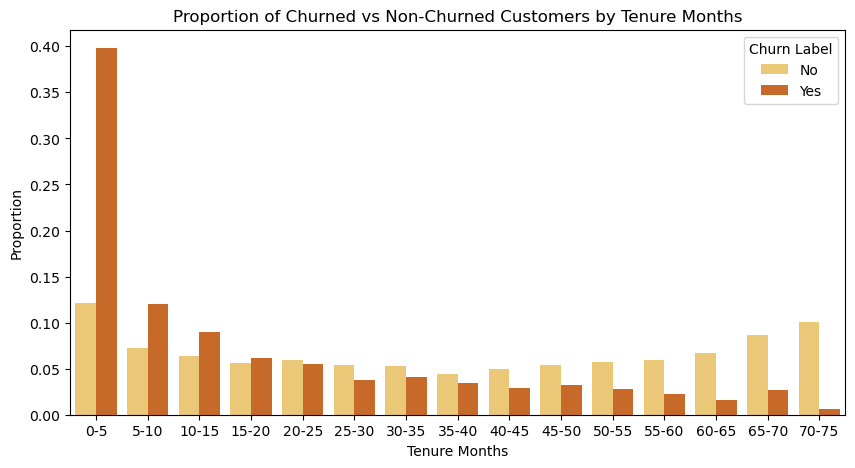

In [69]:
month_buckets = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
month_name = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75']
df_new = df.copy()
df_new['Tenure Buckets'] = pd.cut(df['Tenure Months'],
                       bins = month_buckets,
                       labels = month_name,
                       include_lowest = True)

# Calculate proportions of the churners and non-churners
df_proportion = (
    df_new.groupby("Churn Label")["Tenure Buckets"]
    .value_counts(normalize=True)
    .rename("Proportion")
    .reset_index())

# Create the plot
fig = plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_proportion, 
    x="Tenure Buckets", 
    y="Proportion", 
    hue="Churn Label", 
    palette="YlOrBr")
plt.title("Proportion of Churned vs Non-Churned Customers by Tenure Months")
plt.xlabel("Tenure Months")
plt.savefig('Tenure months.png', bbox_inches='tight')
plt.show()

Another interesting feature is the length of time each customer is using Swan Teleco's services. Customers with 0-5 months tenure show the highest churn proportion (~40%), indicating early-stage churn is a major issue. Before the 20-25 month mark, churned customers outnumber those who remain (in terms of proportions). However, customers with longer tenures (40-45+ months) consistently demonstrate lower churn rates. This suggests that it might be beneficial for Swan Teleco to focus its efforts on newer customers to get them past the 20 month mark because past this point the likelihood is that they will continue to use their services.

To finalise the analysis of what might result in customers churning, we explore the reasons why they decide to leave. 

C:\Users\katri\AppData\Local\Temp\ipykernel_32412\3163235241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn Reason', palette='YlOrBr', order=df['Churn Reason'].value_counts().index)


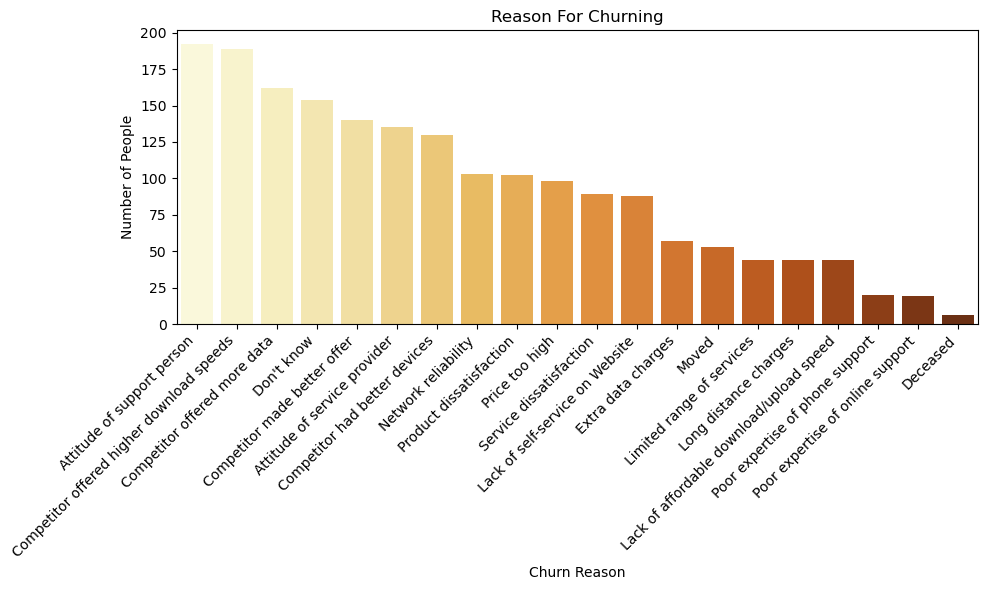

In [71]:
# Count the number of customers in each Churn Reason category and order by count
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Churn Reason', palette='YlOrBr', order=df['Churn Reason'].value_counts().index)

# Set titles and labels
plt.title('Reason For Churning')
plt.xlabel('Churn Reason')
plt.ylabel('Number of People')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('churn_reason_plot.png', bbox_inches='tight')
plt.show()

The graph reveals that the primary reasons for customer churn are better offers from competitors and dissatisfaction with support staff interactions. To address this, we recommend regularly benchmarking your offers against competitors to ensure they remain competitive and attractive. Furthermore, providing comprehensive customer service training for support staff could significantly reduce churn caused by negative customer interactions.